In [1]:
# Western Quant

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import SubplotSpec
from matplotlib.colors import colorConverter
import matplotlib_venn as venn
import numpy as np
import sys
import os

from py_scripts.helpers.homebrew_stats import pairwise_t, mean, standard_deviation, storey
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['font.family'] = "sans-serif"

Loading the module: helpers.homebrew_stats

nummpy        1.19.2
scipy         1.6.1
pandas        1.2.3



In [10]:
def add_errorbar(mpl_axes, x_pos, y_pos, std, color = "grey", x_offset = 0.05, transparency = 0.75):
    """
    Adds error bars to MatPlotLib axes object. Modifies the mpl_axes input, returns None.

    mpl_axes -> matplotlib axes object
    x_pos    -> position of the center of the error bars on the x axis
    y_pos    -> position of the center of the error bars on the y axis
    std      -> standard deviation of the data (or vertical offset for error bars)
    color    -> The color of the error bars (Default: "grey")
    x_offset -> Size of the middle of the error bars (Default: 0.05)
    """
    # Plot the vertical middle bar
    mpl_axes.plot([x_pos, x_pos], [y_pos + std, y_pos - std], color = color, alpha = transparency)
    # Plot the horizontal middle bar
    mpl_axes.plot([x_pos - x_offset, x_pos + x_offset], [y_pos, y_pos], color = color, alpha = transparency)
    # Plot the horizontal top bar
    mpl_axes.plot([x_pos - 0.75*x_offset, x_pos + 0.75*x_offset], [y_pos + std, y_pos + std], color = color, alpha = transparency)
    # Plot the horizontal bottom bar
    mpl_axes.plot([x_pos - 0.75*x_offset, x_pos + 0.75*x_offset], [y_pos - std, y_pos - std], color = color, alpha = transparency)
    return None

def make_sigstrings(pvals, symbol = "*"):
    """
    """
    sigstrings = []
    for p in pvals:
        if p >= 0.05:
            sigstrings.append(f" n.s.")
        elif 0.01 <= p < 0.05:
            sigstrings.append(fr" {symbol}")
        elif 0.001 <= p < 0.01:
            sigstrings.append(fr" {symbol}{symbol}")
        else:
            sigstrings.append(fr" {symbol}{symbol}{symbol}")
    return sigstrings

def get_signal(file_df, channel, signal_column = "Signal", channel_column = "Channel"):
    """
    """
    assert type(channel) == int, "The channel should be a number (700 or 800)."
    assert type(file_df) == type(pd.DataFrame([])), "The data should be in a DataFrame."
    channel_filtered = file_df[file_df[channel_column] == channel]
    return list(channel_filtered[signal_column].astype(float))

def licor_correction(exp_signal, control_signal):
    """
    """
    # Make sure all of the inputs are numbers
    assert all([type(item) == float or type(item) == int for item in exp_signal]), "Signal should be provided as a float."
    assert all([type(item) == float or type(item) == int for item in control_signal]), "Signal should be provided as a float."
    assert len(exp_signal) == len(control_signal), "The exp_signal and control_signal should be index paired lists of the same size."
    # Make the correction factors using the max signal
    corr_facts = [signal / max(control_signal) for signal in control_signal]
    # Correct the experimental signals using the controls
    return [exp_signal[i]/corr_facts[i] for i in range(len(exp_signal))]

def bin_data(signal_list, bins, labels = [], group_sizes = []):
    """
    """
    assert all([type(item) == float or type(item) == int for item in signal_list]), "Signal should be provided as a float."
    assert type(bins) == int, "The number of groups (bins) should be an integer."
    assert type(labels) in [list, tuple], "The labels should be in a list or tuple."
    if group_sizes != []:
        assert all([type(item) == int for item in group_sizes]), "The group sizes should be integers."
        assert len(group_sizes) == bins, "The number of given group sizes does not match the number of groups."
        groups = []
        count = 0
        for item in group_sizes:
            groups.append(signal_list[count:count+item])
            count += item
    else:
        # Assume an even number of things in each bin
        n_members = len(signal_list)//bins
        groups = [signal_list[n_members*i: n_members*(i+1)] for i in range(bins)]
    if labels != []:
        assert all([type(item) == str for item in labels]), "The labels should be strings"
        assert len(labels) == bins, "Each group should have a corresponding label"
        return [(labels[i], groups[i]) for i in range(bins)]
    else:
        return [(f"{i}", groups[i]) for i in range(bins)]

def get_x_positions(corr_signal_groups, width = 7):
    """
    """
    signals = [(item[0], sorted(item[1], reverse = True)) for item in corr_signal_groups]
    x_positions = []
    for i in range(len(signals)):
        if len(signals[i][1]) < width:
            x_positions.append([(i+1)-0.2 + 0.05*(k) for k in range(len(signals[i][1]))])
        else:
            x_positions = []
            if len(signals) % width != 0:
                for j in range(len(signals[i][1])//width):
                    x_positions += [(i+1) - 0.2 + 0.05*(k) for k in range(width)]
            else:
                for j in range(len(signals[i][1])//width):
                    x_positions += [(i+1) - 0.2 + 0.05*(k) for k in range(width)]
                x_positions += [(i+1) - 0.2 + 0.05*(k) for k in range(len(signals[i][1]%width))]
    return x_positions, signals
    
def get_data_info(corr_signal_groups):
    """
    """
    bins = len(corr_signal_groups)
    centers = [i-0.2 + 0.05*(3/2) for i in range(1,bins+1)]
    x_pos, corr_signal_groups = get_x_positions(corr_signal_groups)
    means = []
    sems = []
    for item in corr_signal_groups:
        if len(item[1]) > 1:
            means.append(mean(item[1]))
            sems.append(standard_deviation(item[1]))
        else:
            means.append(*item[1])
            sems.append(float("nan"))
    return corr_signal_groups, {"centers" : centers,
                                "xs"      : x_pos,
                                "means"   : means,
                                "sems"    : sems}

def make_comparisons(mpl_axes,
                     groups,
                     centers,
                     ymax,
                     pw_ttest_optargs = {"omit_comb" : [],
                                         "t_type" : "s", 
                                         "comp_labels" : True},
                     colours = [], 
                     text_dict = {"fontfamily" : "sans-serif",
                                  "font" : "Arial",
                                  "ha" : "left",
                                  "fontweight" : "bold"},
                     filename = None):
    """
    """
    seen_dict = {}
    for group in groups:
        seen_dict[group[0]] = [0,[]]
    comparisons = pairwise_t(*groups, **pw_ttest_optargs)
    if filename != None:
        comparisons.to_excel(filename)
    group_1 = list(comparisons["Group 1"])
    group_2 = list(comparisons["Group 2"])
    pvals = list(comparisons["pvalue"].astype(float))
    sig_strings = make_sigstrings(pvals)
    
    min_bar = max([max(item[1]) for item in groups])
    
    scale = ymax//len(comparisons)
    offset = 0.15
    last_group = None
    text_offset = 0.001
    
    for i in range(len(group_1)):
        current_groups = [pair for pair in groups if pair[0] in [group_1[i], group_2[i]]]
        current_indices = [groups.index(pair) for pair in groups if pair[0] in [group_1[i], group_2[i]]]
        if last_group != current_groups[0]:
            last_group = current_groups[0]
            mpl_axes.plot([centers[current_indices[0]], centers[current_indices[1]]],
                          [min_bar+scale*offset, min_bar + scale*offset], color = "black", alpha = 0.5)
            if sig_strings[i] == "n.s.":
                mpl_axes.text((centers[current_indices[0]] + centers[current_indices[1]])/2,
                              min_bar + scale*offset + text_offset * scale,
                              sig_strings[i], **text_dict)
            else:
                mpl_axes.text((centers[current_indices[0]] + centers[current_indices[1]])/2,
                              min_bar + scale*offset,
                              sig_strings[i], **text_dict)
            seen_dict[current_groups[0][0]][1].append(min_bar+scale*offset)
            seen_dict[current_groups[1][0]][1].append(min_bar+scale*offset)
            seen_dict[current_groups[0][0]][0] = current_indices[0]
            seen_dict[current_groups[1][0]][0] = current_indices[1]
        else:
            mpl_axes.plot([centers[current_indices[0]], centers[current_indices[1]]],
                          [min_bar+scale*offset, min_bar + scale*offset], color = "black", alpha = 0.5)
            if sig_strings[i] == "n.s.":
                mpl_axes.text((centers[current_indices[0]] + centers[current_indices[1]])/2,
                              min_bar + scale*offset + text_offset * scale,
                              sig_strings[i], **text_dict)
            else:
                mpl_axes.text((centers[current_indices[0]] + centers[current_indices[1]])/2,
                              min_bar + scale*offset,
                              sig_strings[i], **text_dict)
            seen_dict[current_groups[0][0]][1].append(min_bar+scale*offset)
            seen_dict[current_groups[1][0]][1].append(min_bar+scale*offset)
            seen_dict[current_groups[0][0]][0] = current_indices[0]
            seen_dict[current_groups[1][0]][0] = current_indices[1]
        offset += 0.15+0.05
    
    for key, value in seen_dict.items():
        if colours == []:
            mpl_axes.plot([centers[value[0]],
                           centers[value[0]]],[max(groups[value[0]][1]), max(value[1])],
                          alpha = 0.5, linestyle = ":", color = "grey")
        else:
            mpl_axes.plot([centers[value[0]],
                           centers[value[0]]],[max(groups[value[0]][1]), max(value[1])],
                          alpha = 0.5, linestyle = ":", color = colours[value[0]])  
    return None

def make_ymax(labelled_groups):
    """
    """
    values = [max(item[1]) for item in labelled_groups]
    total_max = max(values)
    if 1 <= len(labelled_groups) < 5:
        return total_max // 3 + total_max
    elif 5 <= len(labelled_groups) < 10:
        return total_max // 2 + total_max
    else:
        return total_max // 1.5 + total_max


def make_ytick_labels(diff_scaled, n, numstring = ""):
    """
    """
    tick_labels = [i*diff_scaled for i in range(n)]
    new_ticks = []
    for item in tick_labels:
        if int(item) == item:
            new_ticks.append(f"{int(item)}{numstring}")
        else:
            new_ticks.append(f"{item:.1f}{numstring}")
    return new_ticks
    
def update_yticks(mpl_axes, fontdict = {"fontfamily" : "sans-serif",
                                         "font" : "Arial",
                                         "ha" : "right",
                                         "fontweight" : "bold",
                                         "fontsize" : "12"}):
    """
    """
    current = mpl_axes.get_yticks()
    diff = current[-1] - current[0]
    if 0 < diff < 1000:
        diff = current[1]-current[0]
        mpl_axes.set_yticks([i*(diff) for i in range(len(current))])
        mpl_axes.set_yticklabels(make_ytick_labels(diff, len(current)),
                                 **fontdict)
    elif 1000 <= diff <= 999999:
        diff = current[1]-current[0]
        mpl_axes.set_yticks([i*(diff) for i in range(len(current))])
        mpl_axes.set_yticklabels(make_ytick_labels(diff/1000, len(current), "K"),
                                 **fontdict)
    elif 1000000 <= diff:
        diff = current[1]-current[0]
        mpl_axes.set_yticks([i*(diff) for i in range(len(current))])
        mpl_axes.set_yticklabels(make_ytick_labels(diff/1000000, len(current), "M"),
                                 **fontdict)

def update_xticks(mpl_axes,
                  xpos,
                  xlabels,
                  fontdict = {"fontfamily" : "sans-serif",
                               "font" : "Arial",
                               "ha" : "center",
                               "fontweight" : "bold",
                               "fontsize" : "12"}):
    """
    """
    mpl_axes.set_xticks(xpos)
    mpl_axes.set_xticklabels(xlabels, **fontdict)
        

tab_colours = ["tab:blue", "tab:orange", "tab:green", "tab:red",
               "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]

def add_relative_axis(mpl_axes,
                      rel_group,
                      groups,
                      info_dict,
                      fontdict = {"fontfamily" : "sans-serif",
                               "font" : "Arial",
                               "ha" : "left",
                               "fontweight" : "bold",
                               "fontsize" : "12"},
                      ylabel = "Fold Change"):
    """
    """
    rel_index = [i for i in range(len(groups)) if rel_group in groups[i]]
    data_scaled = [(item[0], [value / info_dict["means"][rel_index[0]] 
                              for value in item[1]])
                   for item in groups]
    new_y = mpl_axes.twinx()
    ymax = make_ymax(data_scaled)
    current_lims = mpl_axes.get_ylim()
    new_y.set_ylim(current_lims[0] / info_dict["means"][rel_index[0]],
                   current_lims[1] / info_dict["means"][rel_index[0]])
    for i in range(len(data_scaled)):
        new_y.scatter(info_dict["xs"][i], data_scaled[i][1], alpha = 0)
    update_yticks(new_y, fontdict = fontdict)
    current_lims = mpl_axes.get_ylim()
    new_y.set_ylim(current_lims[0] / info_dict["means"][rel_index[0]],
                   current_lims[1] / info_dict["means"][rel_index[0]])
    new_y.set_ylabel(ylabel,
                     font = "Arial",
                     fontsize = 14,
                     fontweight = "bold",
                     rotation = 270, va = "baseline")
    return None

def plot_dotplot(labelled_groups,
                 foldchange_axis = False,
                 foldchange_group = None,
                 filename = "dotplot.pdf",
                 colours = [],
                 title = "Dotplot",
                 xlabel = "",
                 ylabel = "Abundance"):
    """
    """
    global tab_colours
    xls_file = filename.split(".")[0]
    groups, info_dict = get_data_info(labelled_groups)
    ymax = make_ymax(labelled_groups)
    fig, ax = plt.subplots()
    ax.set_ylim(0,ymax)
    for i in range(len(groups)):
        if colours == []:
            ax.scatter(info_dict["xs"][i], groups[i][1], edgecolors = "black")
            add_errorbar(ax, info_dict["centers"][i], info_dict["means"][i], info_dict["sems"][i])
        elif colours != []:
            ax.scatter(info_dict["xs"][i], groups[i][1], edgecolors = "black", color = colours[i])
            add_errorbar(ax, info_dict["centers"][i], info_dict["means"][i], info_dict["sems"][i])
    if colours == []:
        make_comparisons(ax, groups, info_dict["centers"],
                         ymax, colours = tab_colours,
                         filename = f"{xls_file}.xlsx")
    else:
        make_comparisons(ax, groups, info_dict["centers"],
                         ymax, filename = f"{xls_file}.xlsx")
    update_yticks(ax)
    update_xticks(ax, info_dict["centers"], [item[0] for item in groups])
    ax.set_ylim(0,ymax)
    if foldchange_axis and foldchange_group != None:
        add_relative_axis(ax, foldchange_group, groups, info_dict)
    ax.set_xlabel(xlabel, **{"fontfamily" : "sans-serif",
                               "font" : "Arial",
                               "ha" : "center",
                               "fontweight" : "bold",
                               "fontsize" : "14"})
    ax.set_ylabel(ylabel, **{"fontfamily" : "sans-serif",
                               "font" : "Arial",
                               "ha" : "center",
                               "fontweight" : "bold",
                               "fontsize" : "14"})
    ax.set_title(title, **{"fontfamily" : "sans-serif",
                               "font" : "Arial",
                               "ha" : "center",
                               "fontweight" : "bold",
                               "fontsize" : "16"})
    plt.savefig(filename, bbox_inches = "tight")
    plt.show()
    return None

def western_quant(file1,
                  file2 = None, 
                  exp_channel = 800, 
                  control_channel = 700,
                  bins = 4,
                  labels = [],
                  group_sizes = [],
                  filename = "dotplot.pdf",
                  title = "Dotplot",
                  xlabel = "",
                  ylabel = "Abundance",
                  colours = [],
                  foldchange_axis = False,
                  foldchange_group = None):
    """
    """
    file = pd.read_excel(file1)
    if file2 == None:
        exp_signal = get_signal(file,
                                exp_channel)
        control_signal = get_signal(file,
                                    control_channel)
        corr_signal = licor_correction(exp_signal,
                                       control_signal)
        groups = bin_data(corr_signal,
                          bins = bins,
                          labels = labels,
                          group_sizes = group_sizes)
        plot_dotplot(groups,
                     filename = filename,
                     colours = colours,
                     title = title,
                     xlabel = xlabel,
                     ylabel = ylabel,
                     foldchange_axis = foldchange_axis,
                     foldchange_group = foldchange_group)
    else:
        file_2 = pd.read_excel(file2)
        exp_signal = get_signal(file,
                                exp_channel)
        control_signal = get_signal(file_2,
                                    control_channel)
        corr_signal = licor_correction(exp_signal,
                                       control_signal)
        groups = bin_data(corr_signal,
                          bins = bins,
                          labels = labels,
                          group_sizes = group_sizes)
        plot_dotplot(groups,
                     filename = filename,
                     colours = colours,
                     title = title,
                     xlabel = xlabel,
                     ylabel = ylabel,
                     foldchange_axis = foldchange_axis,
                     foldchange_group = foldchange_group)
    return None

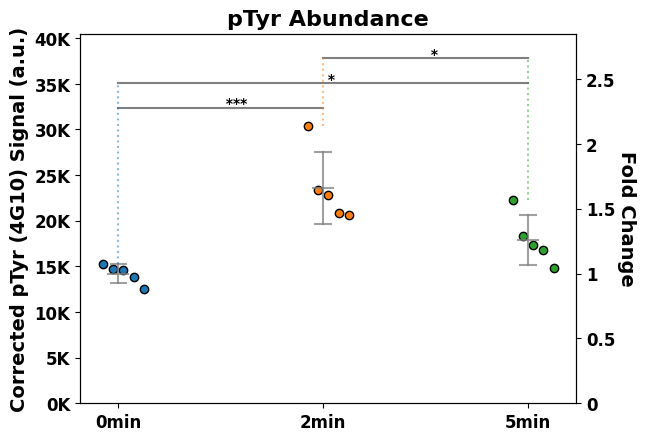

In [11]:
western_quant("western_blot_data/Supplementary Folder 1 File A proteomics pTyr Western Quantification.xls",
              bins = 3,
              exp_channel = 800,
              control_channel = 700,
              filename = "western_blot_data/Supplementary Folder 1 File A proteomics pTyr Western Statistics.pdf",
              labels = ["0min", "2min", "5min"],
              title = "pTyr Abundance",
              ylabel = "Corrected pTyr (4G10) Signal (a.u.)",
              foldchange_axis = True,
              foldchange_group = "0min")

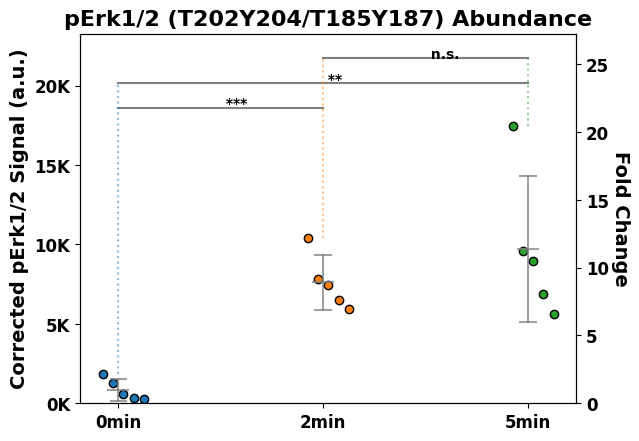

In [12]:
western_quant("western_blot_data/Supplementary Folder 1 File B proteomics pErk Western Quantification.xls",
              bins = 3,
              exp_channel = 700,
              control_channel = 800,
              filename = "western_blot_data/Supplementary Folder 1 File B proteomics pErk Western Statistics.pdf",
              labels = ["0min", "2min", "5min"],
              title = "pErk1/2 (T202Y204/T185Y187) Abundance",
              ylabel = "Corrected pErk1/2 Signal (a.u.)",
              foldchange_axis = True,
              foldchange_group = "0min")

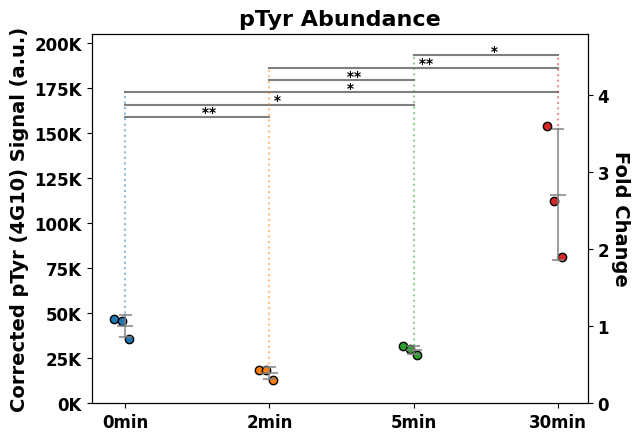

In [13]:
western_quant("western_blot_data/Supplementary Folder 1 File C CD19-CAR T cell 30m coculture pTyr Western Quantification.xls",
              bins = 4,
              exp_channel = 800,
              control_channel = 700,
              filename = "western_blot_data/Supplementary Folder 1 File C CD19-CAR T cell 30 minute coculture pTyr Western Statistics.pdf",
              labels = ["0min", "2min", "5min", "30min"],
              title = "pTyr Abundance",
              ylabel = "Corrected pTyr (4G10) Signal (a.u.)",
              foldchange_axis = True,
              foldchange_group = "0min")

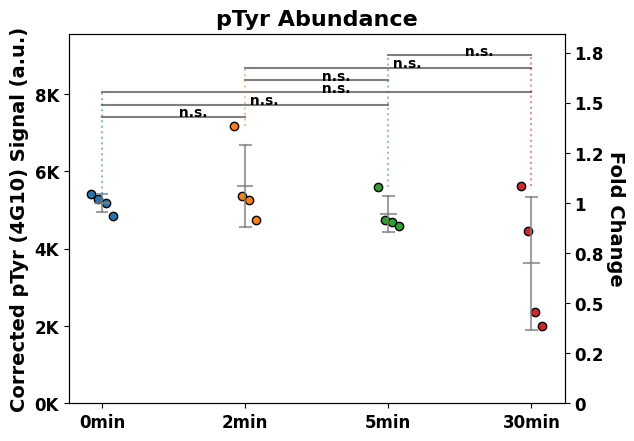

In [15]:
western_quant("western_blot_data/Supplementary Folder 1 File D Jurkat E6  30 minute coculture pTyr Western Quantification.xls",
              bins = 4,
              exp_channel = 800,
              control_channel = 700,
              filename = "western_blot_data/Supplementary Folder 1 File D Jurkat E6  30 minute coculture pTyr Western Quantification.pdf",
              labels = ["0min", "2min", "5min", "30min"],
              title = "pTyr Abundance",
              ylabel = "Corrected pTyr (4G10) Signal (a.u.)",
              foldchange_axis = True,
              foldchange_group = "0min")